In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import pathlib

sys.path.append("/home/mas138/sandbox/dev/MDAqc/")
from src import PSDTools
from src import extra_tools

%matplotlib inline

In [3]:
p = pathlib.Path("/home/mas138/orchestra/data/BSM/Cell/1465/MDAqc/1x/psd/")
f_list = sorted(p.glob("*.chroms.spec"))
sample_list = [f.name.split('.chroms.spec')[0] for f in f_list]
psd_list = [PSDTools.SamplePSD(pd.read_table(str(f), index_col=0), name=f.name) for f in f_list]

In [4]:
j_list = [psd.KL_div_by_chrom() for psd in psd_list]
df_chrom = extra_tools.summarize_KL_div_by_chrom(j_list, sample_list)

In [5]:
ind = j_list[0].index.astype(int)
df_kl = pd.DataFrame(np.array(j_list).T, columns=sample_list, index=ind)

In [6]:
df_kl_sort = df_kl.sort_index()
df_kl_sort['chrom'] = df_kl_sort.index

In [7]:
df_kl_melt = pd.melt(df_kl_sort, id_vars='chrom')

In [8]:
df_kl_melt[0:5]
df_kl_melt['Classification'] = 'Pass'
df_kl_melt.loc[df_kl_melt.chrom.isin([15, 16, 17, 19, 20, 21, 22]), 'Classification']='Fail'
# df_kl_melt.loc[df_kl_melt.chrom.isin([9, 15, 16, 17, 19, 20, 21, 22]), 'Classification']='Fail'

In [9]:
df_fail = df_kl_melt[df_kl_melt.chrom.isin([9, 15, 16, 17, 19, 20, 21, 22])]
df_pass = df_kl_melt[~df_kl_melt.chrom.isin([9, 15, 16, 17, 19, 20, 21, 22])]

In [10]:
df_cn = pd.read_table("1465_CN.txt", index_col=0)

In [11]:
df_aut = df_cn.iloc[:-2, :-2]
df_aut.index = df_aut.index.astype(int)
df_aut_sort = df_aut.sort_index()

df_bulk = df_cn.iloc[:-2, -2:]
df_bulk.index = df_bulk.index.astype(int)
df_bulk_sort = df_bulk.sort_index()

In [18]:
cn_avg = df_aut_sort.mean(axis=1)
cn_se = df_aut_sort.std(axis=1)

In [17]:
cn_avg

1    -0.203785
2    -0.106490
3    -0.081008
4    -0.025869
5    -0.085463
6    -0.049289
7    -0.184857
8    -0.059853
9    -0.173753
10   -0.236726
11   -0.148762
12   -0.184128
13   -0.092592
14   -0.194627
15   -0.234433
16   -0.546980
17   -0.701758
18   -0.104458
19   -1.209581
20   -0.440877
21   -0.295009
22   -0.918264
dtype: float64

In [12]:
sns.set_context("poster")
sns.set_style("ticks", {'ytick.minor.size': 0.0, 'xtick.minor.size': 0.0})

In [13]:
import matplotlib.gridspec as gridspec

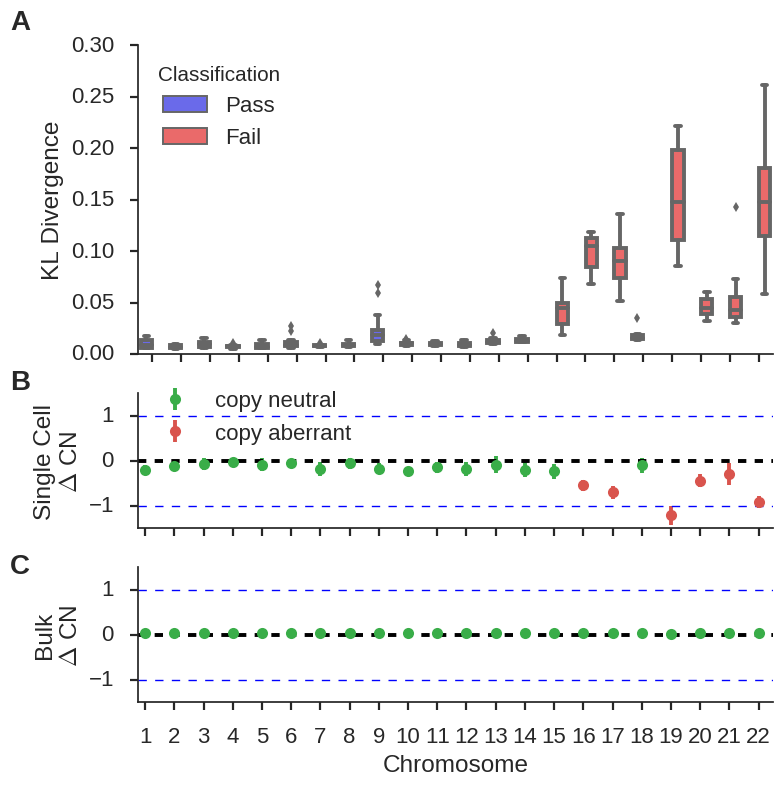

In [30]:
f = plt.figure(figsize=(8, 8))
gs = gridspec.GridSpec(4, 1)#, height_ratios=[3, 1, 1])
ax0 = plt.subplot(gs[0:2])
ax1 = plt.subplot(gs[2])
ax2 = plt.subplot(gs[3])
#ax0 = plt.subplot2grid((4, 1), (0, 0), rowspan=2)
#ax1 = plt.subplot2grid((4, 1), (2, 0))
#ax2 = plt.subplot2grid((4, 1), (3, 0))

sns.boxplot(x='chrom', y='value', hue='Classification', data=df_kl_melt, palette='seismic', ax=ax0)
ax0.set_xlabel('')
ax0.set_ylabel('KL Divergence')
ax0.set_xticklabels([])

colors = ['green' if val>-0.26 else 'red' for val in cn_avg]
chrom = df_aut_sort.index
#im = ax1.imshow(cn_avg.reshape(1,22), cmap='RdBu', interpolation='nearest', vmin=-1.5, vmax=1.5) # aspect='auto')
#ax1.set_yticks([])

# ax1.imshow(df_aut_sort.as_matrix().T, cmap='RdBu', interpolation='nearest', vmin=-1, vmax=1)
ax1.plot((0.75, 22.5), (1, 1), 'b--', lw=1)
ax1.plot((0.75, 22.5), (-1, -1), 'b--', lw=1)
ax1.plot((0.75, 22.5), (0, 0), 'k--')
ax1.errorbar(chrom[(cn_avg>-0.26).as_matrix()], cn_avg[cn_avg>-0.26], 2*cn_se[cn_avg>-0.26], fmt='o', ms=8, color=sns.xkcd_rgb['medium green'], label='copy neutral')
ax1.errorbar(chrom[(cn_avg<-0.26).as_matrix()], cn_avg[cn_avg<-0.26], 2*cn_se[cn_avg<-0.26], fmt='o', ms=8, color=sns.xkcd_rgb['pale red'], label='copy aberrant')
ax1.set_xticks(np.arange(1, 23))
ax1.set_ylim(-1.5, 1.5)
ax1.set_xlim(0.75, 22.5)
ax1.set_yticks([-1, 0, 1])
ax1.set_ylabel("Single Cell\n$\Delta$ CN")
ax1.set_xticklabels([])
ax1.legend(loc=(0.01, 0.56))

# im = ax2.imshow(df_bulk_sort.iloc[:,0].as_matrix().reshape(1,22), cmap='RdBu', interpolation='nearest', vmin=-1.5, vmax=1.5) # aspect='auto')
# f.colorbar(im, ticks=[-1, 0, 1], orientation='horizontal')
ax2.plot((0.75, 22.5), (1, 1), 'b--', lw=1)
ax2.plot((0.75, 22.5), (-1, -1), 'b--', lw=1)
ax2.plot((0.75, 22.5), (0, 0), 'k--')
ax2.plot(chrom, df_bulk_sort.iloc[:, 0], 'o', ms=8, color=sns.xkcd_rgb['medium green'])
ax2.set_xticks(np.arange(1, 23))
ax2.set_ylim(-1.5, 1.5)
ax2.set_xlim(0.75, 22.5)
ax2.set_yticks([-1, 0, 1])
ax2.set_xlabel("Chromosome")
ax2.set_ylabel("Bulk\n$\Delta$ CN")


sns.despine(top=True)
# sns.despine(fig=f, ax=ax2, left=True)

f.text(0.01, 0.98, "A", weight="bold", horizontalalignment='left', verticalalignment='center', fontsize=20)
f.text(0.01, 0.53, "B", weight="bold", horizontalalignment='left', verticalalignment='center', fontsize=20)
f.text(0.01, 0.3, "C", weight="bold", horizontalalignment='left', verticalalignment='center', fontsize=20)
plt.tight_layout()

In [31]:
f.savefig("figs/Fig5_chrom_outlier_06-26-2017.pdf")
f.savefig("figs/Fig5_chrom_outlier_06-26-2017.png")

In [118]:
2**-0.25 - 1

-0.1591035847462855

In [26]:
cn_avg.shape

(22,)

In [38]:
cn_avg.reshape(1, 22)

array([[-0.19865053, -0.10541997, -0.08786161, -0.03201278, -0.08282351,
        -0.03365666, -0.1787842 , -0.07169082, -0.17411611, -0.25058126,
        -0.14041238, -0.1676418 , -0.08709394, -0.19383381, -0.22342476,
        -0.55789852, -0.69870741, -0.08097809, -1.18419796, -0.44447697,
        -0.2843149 , -0.90765555]])

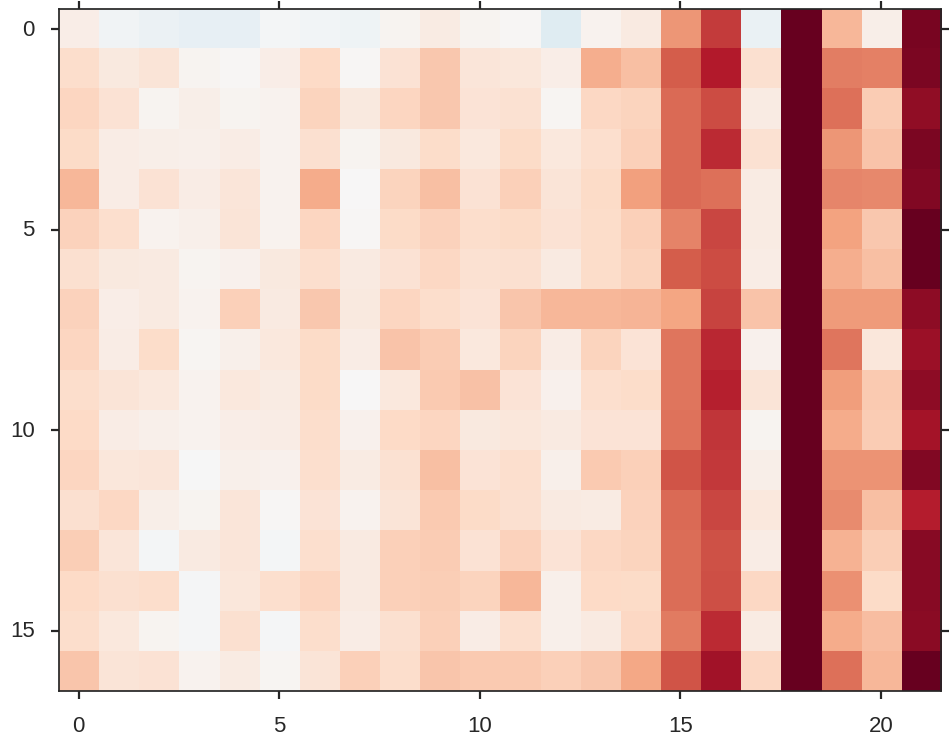

In [35]:
plt.imshow(df_aut_sort.as_matrix().T, cmap='RdBu', interpolation='nearest', vmin=-1, vmax=1)

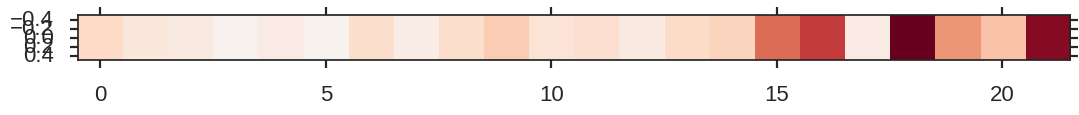

In [39]:
plt.imshow(cn_avg.reshape(1,22), cmap='RdBu', interpolation='nearest', vmin=-1, vmax=1)